# ALI/BiGAN

## Theory

The adversarially learned inference (ALI) model **jointly** learns a generation network and an inference network using an adversarial process. The generation network maps samples from stochastic latent variables to the data space while the inference network maps training examples in data space to the space of latent variables. An adversarial game is cast between these two networks and a discriminative network is trained to distinguish between joint latent/data-space samples from the generative network and joint samples from the inference network.

Consider the two following probability distributions over $x$ and $z$:

+ the encoder joint distribution $q(x, z) = q(x) q(z | x)$,
+ the decoder joint distribution $p(x, z) = p(z) p(x | z)$.

These two distributions have marginals that are known to us: the encoder marginal $q(x)$ is the empirical data distribution and the decoder marginal $p(z)$ is usually defined to be a simple, factorized distribution, such as the standard Normal distribution $p(z) = \mathcal{N} (0, I)$. As such, the generative process between $q(x, z)$ and $p(x, z)$ is reversed.

**ALI’s objective is to match the two joint distributions.** If this is achieved, then we are ensured that all marginals match and all conditional distributions also match. In particular, we are assured that the conditional $q(z | x)$ matches the posterior $p(z | x)$.

In order to match the joint distributions, an adversarial game is played. Joint pairs $(x, z)$ are drawn either from $q(x, z)$ or $p(x, z)$, and a discriminator network learns to discriminate between the two, while the encoder and decoder networks are trained to fool the discriminator.

The value function describing the game is given by:

$$\min_G \max_D V(D, G) = \mathbb{E}_{q(x)} [\log (D(x, G_z(x)))] + \mathbb{E}_{p(z)} [\log (1 - D(G_x(z), z))] \\
= \iint q(x) q(z | x) \log (D(x, z)) dx dz + \iint p(z) p(x | z) \log (1 - D(x, z)) dx dz.$$

ALI’s approach is also reminiscent of the **Adversarial AutoEncoder** model, which employs a GAN to distinguish between samples from the approximate posterior distribution $q(z | x)$ and prior samples. However, unlike adversarial autoencoders, **no explicit reconstruction loss is being optimized in ALI**, and the discriminator receives joint pairs of samples $(x, z)$ rather than marginal z samples.

Independent work by Donahue et al. proposes the same model under the name **Bidirectional GAN (BiGAN)**, in which the authors emphasize the learned features’ usefulness for auxiliary supervised and semi-supervised tasks. The main difference in terms of experimental setting is that they use a **deterministic** $q(z | x)$ network, whereas we use a **stochastic** network. In our experience, this does not make a big difference when $x$ is a deterministic function of $z$ as the stochastic inference networks tend to become determinstic as training progresses. When using stochastic mappings from $z$ to $x$, the additional flexiblity of stochastic posteriors is critical.


## Advantages and Limitations

+ The ability of the model to learn mutually coherent inference and generation networks through the inspections of model samples and reconstructions;
+ The usefulness of the learned representations.

## References

V. Dumoulin, et al., Adversarially Learned Inference, ICLR 2017.

J. Donahue, et al., Adversarial Feature Learning, ICLR 2017.

J. Donahue and K. Simonyan, Large Scale Adversarial Representation Learning, 2019.

In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True, source_url= 'http://yann.lecun.com/exdb/mnist/')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
mb_size = 128
X_dim = mnist.train.images.shape[1]
Z_dim = 64
h_dim = 128

lr = 1e-3
d_steps = 3

+ Initialization

In [4]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [5]:
X = tf.placeholder(tf.float32, shape=[None, X_dim])
Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

D_W1 = tf.Variable(xavier_init([X_dim + Z_dim, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))
D_W2 = tf.Variable(xavier_init([h_dim, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

Q_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))
Q_W2 = tf.Variable(xavier_init([h_dim, Z_dim]))
Q_b2 = tf.Variable(tf.zeros(shape=[Z_dim]))

P_W1 = tf.Variable(xavier_init([Z_dim, h_dim]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]))
P_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
P_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [Q_W1, Q_W2, Q_b1, Q_b2, P_W1, P_W2, P_b1, P_b2]

+ Latent/hidden variable $z$ can sample from any distributions, e.g., uniform distribution or normal distribution.

In [6]:
def sample_Z(m, n):
    
    return np.random.uniform(-1., 1., size=[m, n])

+ Generator $Q$, $P$ and Discriminator $D$ are three networks, e.g., ConvNets or Multi-Layer Perceptrons (MLP). Here, Two-Layer Full-Connected Forward Feedback NN.

In [7]:
# generators

# encoder, or inference network
def Q(X):
    Q_h1 = tf.nn.relu(tf.matmul(X, Q_W1) + Q_b1)
    Q_logit = tf.matmul(Q_h1, Q_W2) + Q_b2
    
    return Q_logit

# decoder, or generation network
def P(Z):
    P_h1 = tf.nn.relu(tf.matmul(Z, P_W1) + P_b1)
    P_log_prob = tf.matmul(P_h1, P_W2) + P_b2
    P_prob = tf.nn.sigmoid(P_log_prob)
    
    return P_prob

# discriminator
def D(X, Z):
    inputs = tf.concat([X, Z], axis=1)
    D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)
    D_log_prob = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_log_prob)
    
    return D_prob

In [8]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [9]:
Z_hat = Q(X)
X_hat = P(Z)

D_real = D(X, Z_hat)
D_fake = D(X_hat, Z)

+ Loss functions
+ We can use some optimization algorithms with different learning rates

In [10]:
def log(x):
    
    return tf.log(x + 1e-8)

In [11]:
D_loss = -tf.reduce_mean(log(D_real) + log(1 - D_fake))
G_loss = -tf.reduce_mean(log(D_fake) + log(1 - D_real))

D_solver = (tf.train.AdamOptimizer(learning_rate=lr).minimize(D_loss, var_list=theta_D))
G_solver = (tf.train.AdamOptimizer(learning_rate=lr).minimize(G_loss, var_list=theta_G))

+ Here, $k = 1$

In [12]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('GAN-ALI_BiGAN/'):
    os.makedirs('GAN-ALI_BiGAN/')

avg_costs = {'discriminator': [], 'generator': []}

i = 0

for it in range(50000):
    X_mb, _ = mnist.train.next_batch(mb_size)
    Z_mb = sample_Z(mb_size, Z_dim)

    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: Z_mb})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={X: X_mb, Z: Z_mb})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D_loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print('\n')
        
        n_sample = 16
        
        samples = sess.run(X_hat, feed_dict={Z: sample_Z(n_sample, Z_dim)})

        fig = plot(samples)
        plt.savefig('GAN-ALI_BiGAN/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)
        
        avg_costs['discriminator'].append(D_loss_curr / n_sample)
        avg_costs['generator'].append(G_loss_curr / n_sample)

Iter: 0
D_loss: 1.386
G_loss: 3.213


Iter: 1000
D_loss: 0.03235
G_loss: 28.82


Iter: 2000
D_loss: 0.001699
G_loss: 29.82


Iter: 3000
D_loss: 0.06409
G_loss: 31.32


Iter: 4000
D_loss: 0.003305
G_loss: 28.43


Iter: 5000
D_loss: 0.0001129
G_loss: 29.1


Iter: 6000
D_loss: 0.0001086
G_loss: 30.83


Iter: 7000
D_loss: 3.421e-06
G_loss: 36.64


Iter: 8000
D_loss: 0.0155
G_loss: 31.87


Iter: 9000
D_loss: 0.03652
G_loss: 30.44


Iter: 10000
D_loss: 0.1089
G_loss: 29.36


Iter: 11000
D_loss: 0.02641
G_loss: 26.21


Iter: 12000
D_loss: 0.09225
G_loss: 23.51


Iter: 13000
D_loss: 0.2178
G_loss: 20.01


Iter: 14000
D_loss: 0.1359
G_loss: 17.88


Iter: 15000
D_loss: 0.1264
G_loss: 21.26


Iter: 16000
D_loss: 0.1433
G_loss: 17.86


Iter: 17000
D_loss: 0.1199
G_loss: 19.0


Iter: 18000
D_loss: 0.3736
G_loss: 16.37


Iter: 19000
D_loss: 0.3659
G_loss: 16.35


Iter: 20000
D_loss: 0.3979
G_loss: 15.37


Iter: 21000
D_loss: 0.2365
G_loss: 15.38


Iter: 22000
D_loss: 0.2725
G_loss: 14.51


Iter: 230

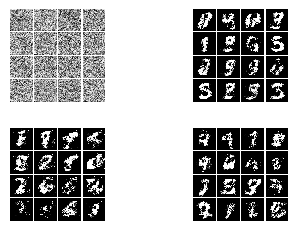

In [15]:
plt.figure()

ax = plt.subplot(221)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan1 = plt.imread('GAN-ALI_BiGAN/000.png')
plt.imshow(gan1, cmap='Greys_r')

ax = plt.subplot(222)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan2 = plt.imread('GAN-ALI_BiGAN/015.png')
plt.imshow(gan2, cmap='Greys_r')

ax = plt.subplot(223)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan3 = plt.imread('GAN-ALI_BiGAN/030.png')
plt.imshow(gan3, cmap='Greys_r')

ax = plt.subplot(224)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan4 = plt.imread('GAN-ALI_BiGAN/045.png')
plt.imshow(gan4, cmap='Greys_r')

plt.show()

+ Performance estimation

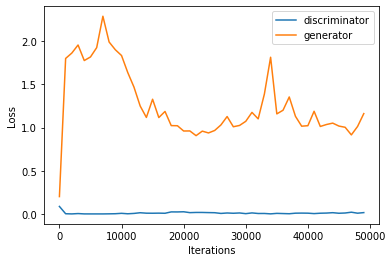

In [16]:
# plotting the learning curves
plt.figure()
plt.plot(np.arange(len(avg_costs['discriminator']))*1000, avg_costs['discriminator'], label='discriminator')
plt.plot(np.arange(len(avg_costs['generator']))*1000, avg_costs['generator'], label='generator')
plt.xlabel(r'Iterations')
plt.ylabel(r'Loss')
plt.legend()
plt.show()